# **Install and Imports**

In [ ]:
!pip install -q torchmetrics
!pip install -q efficientnet_pytorch
!pip install -q torchsampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets  
from torchvision import transforms as T
from torch.optim import lr_scheduler
from torchsampler import ImbalancedDatasetSampler

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, Recall, Precision
from torchmetrics.functional import accuracy, f1_score
from tqdm import tqdm
import time

# **Chest CT-Scan Dataset 🗂️**

Step1: Download dataset Link in Kaggle:
https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images

Step2: Upload data to your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Freelancing/chest_CT-scan/data/dataset /content/Chest_CT-Scan

In [ ]:
# Data transform
transform_train = T.Compose([T.RandomResizedCrop(size=(224, 224), 
                                                 scale=(0.8, 1.0)),
                             T.RandomHorizontalFlip(),
                             T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], 
                                           p=0.2),
                             T.RandomGrayscale(0.5),
                             T.ToTensor(),
                             T.Normalize((0.4914, 0.4822, 0.4465), 
                                         (0.2023, 0.1994, 0.2010))])

transform_test = T.Compose([T.Resize((224, 224)),
                            T.ToTensor(),
                            T.Normalize((0.4914, 0.4822, 0.4465), 
                                        (0.2023, 0.1994, 0.2010))])

### **DatatLoader and ImbalancedDatasetSampler**

In [ ]:
train_set = datasets.ImageFolder('/content/Chest_CT-Scan/train/', 
                                 transform=transform_train)

valid_set = datasets.ImageFolder('/content/Chest_CT-Scan/valid/', 
                                 transform=transform_test)

test_set = datasets.ImageFolder('/content/Chest_CT-Scan/test/', 
                                 transform=transform_test)

sampler = ImbalancedDatasetSampler(train_set)

train_loader = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=2)

### **Details of dataset**

In [ ]:
num_class_train = len(train_set.classes)
num_class_valid = len(valid_set.classes)
num_class_test = len(test_set.classes)

print(f'The number of classes in train: {num_class_train}')
print(f'The number of classes in valid: {num_class_valid}')
print(f'The number of classes in test: {num_class_test}')
print()
print('The number of train set: ', len(train_set))
print('The number of valid set: ', len(valid_set))
print('The number of test set: ', len(test_set))

The number of classes in train: 4
The number of classes in valid: 4
The number of classes in test: 4

The number of train set:  613
The number of valid set:  72
The number of test set:  315


### **Batch shape and class labels**

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
train_set.class_to_idx

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

## Visualize one batch of dataset

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize=True):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(12, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        if normalize:
            image = normalize_image(image)

            ax.imshow(image.permute(1, 2, 0).cpu().numpy())
            ax.set_title(classes[labels[i]])
            ax.axis('off')

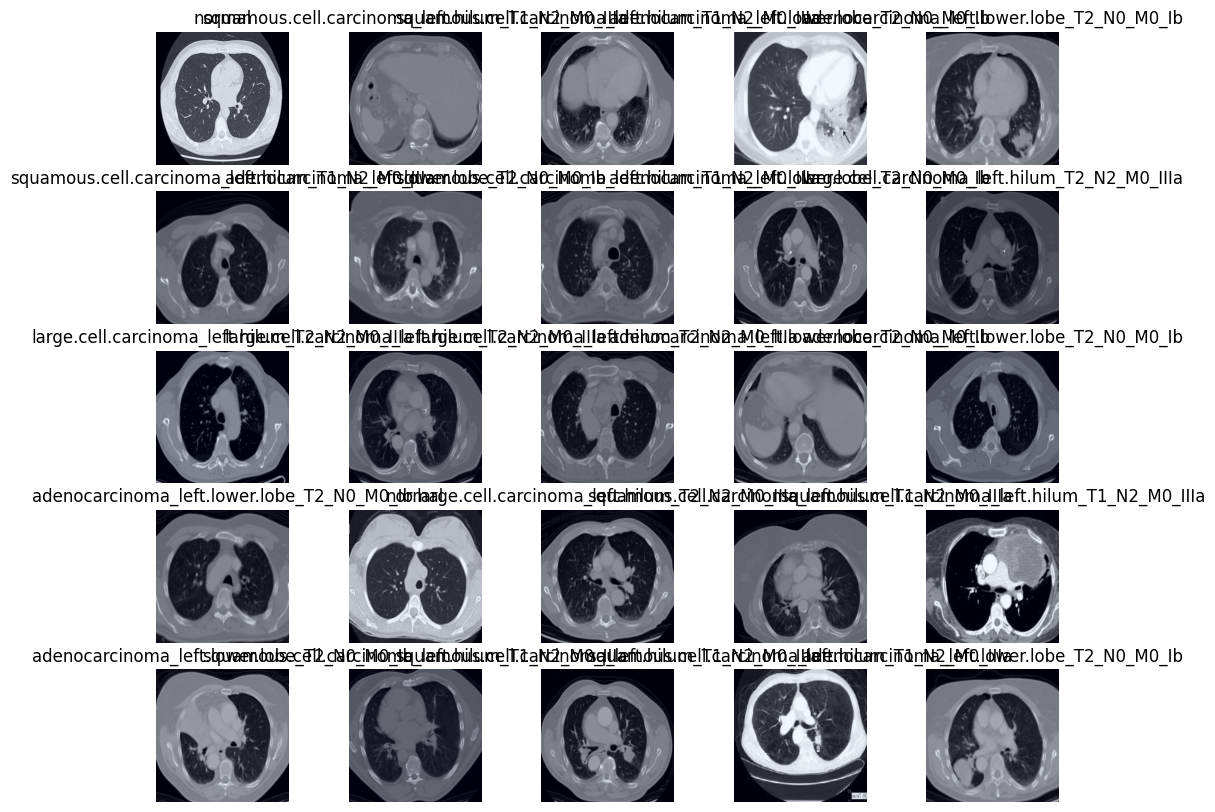

In [ ]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Define Model**

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

# Set the number of output classes
num_classes = 4

# Replace the last fully connected layer with a new one
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:20<00:00, 1.06MB/s]

Loaded pretrained weights for efficientnet-b0


# **Device and num params**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [ ]:
def num_params(model):
    nums = sum(p.numel() for p in model.parameters())/1e6
    return nums

In [ ]:
num_params(model)

4.012672

# **Loss & Optimizer**

In [ ]:
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

CrossEntropyLoss()

# **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

# **Functions** 

In [ ]:
import torchmetrics as tm

acc_tracker_train = AverageMeter(name='acc')
loss_tracker_train = AverageMeter(name='loss')
f1_tracker_train = AverageMeter(name='f1')
recall_tracker_train = AverageMeter(name='recall')

def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):

    model.train()
    acc_tracker_train.reset()
    loss_tracker_train.reset()
    f1_tracker_train.reset()
    recall_tracker_train.reset()

    with tqdm(train_loader, unit="batch", ascii=" #") as tepoch:
        for inputs, targets in tepoch:
            if epoch is not None:
                tepoch.set_description(f"Epoch {epoch}")
                inputs = inputs.to(device)
                targets = targets.to(device)

                # forward
                outputs = model(inputs)

                # backward
                loss = loss_fn(outputs, targets)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # metrics
                acc = tm.functional.accuracy(outputs, targets, 
                                             task='multiclass',
                                             num_classes=4,
                                             average='weighted')
                
                f1 = tm.functional.f1_score(outputs.argmax(1), targets, 
                                            task='multiclass', 
                                            num_classes=4,
                                            average='weighted')
                
                recall = tm.functional.recall(outputs.argmax(1), targets, 
                                              task='multiclass',
                                              num_classes=4,
                                              average='weighted')

                acc_tracker_train.update(acc.item())
                loss_tracker_train.update(loss.item())
                f1_tracker_train.update(f1.item())
                recall_tracker_train.update(recall.item())

                avg_train_loss = loss_tracker_train.avg
                avg_train_acc = acc_tracker_train.avg
                avg_train_f1 = f1_tracker_train.avg
                avg_train_recall = recall_tracker_train.avg

                tepoch.set_postfix(loss=avg_train_loss, 
                                   acc=avg_train_acc,
                                   f1=avg_train_f1,
                                   recall=avg_train_recall)
                
        scheduler.step()
        print(f'Epoch {epoch}: Learning rate = {scheduler.get_last_lr()[0]}')           
        return model, avg_train_loss, avg_train_acc, avg_train_f1, avg_train_recall

In [ ]:
acc_tracker_val = AverageMeter(name='acc')
loss_tracker_val = AverageMeter(name='loss')
f1_tracker_val = AverageMeter(name='f1')
recall_tracker_val = AverageMeter(name='recall')

def validation(model, val_loader, loss_fn):

    model.eval()
    acc_tracker_val.reset()
    loss_tracker_val.reset()
    f1_tracker_val.reset()
    recall_tracker_val.reset()

    with tqdm(test_loader, unit="batch", ascii=" *") as tepoch:
        for inputs, targets in tepoch:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward
            outputs = model(inputs)

            # metrics
            acc = tm.functional.accuracy(outputs, targets,
                                         task='multiclass',
                                         num_classes=4,
                                         average='weighted')
            
            f1 = tm.functional.f1_score(outputs.argmax(1), targets,  
                                        task='multiclass', 
                                        num_classes=4, 
                                        average='weighted',)
            
            recall = tm.functional.recall(outputs.argmax(1), targets, 
                                           task='multiclass', 
                                           num_classes=4,
                                           average='weighted')

            loss = loss_fn(outputs, targets)

            acc_tracker_val.update(acc.item())
            loss_tracker_val.update(loss.item())
            f1_tracker_val.update(f1.item())
            recall_tracker_val.update(recall.item())

            avg_val_loss = loss_tracker_val.avg
            avg_val_acc = acc_tracker_val.avg
            avg_val_f1 = f1_tracker_val.avg
            avg_val_recall = recall_tracker_val.avg

            tepoch.set_postfix(loss=avg_val_loss, 
                               acc=avg_val_acc,
                               f1=avg_val_f1,
                               recall=avg_val_recall)
            
        return avg_val_loss, avg_val_acc, avg_val_f1, avg_val_recall

## Train

In [ ]:
loss_train_hist = []
loss_valid_hist = []

f1_train_hist = []
f1_valid_hist = []

recall_train_hist = []
recall_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
    # Train
    model, loss_train, acc_train, f1_train, recall_train = train_one_epoch(model,
                                                                           train_loader, 
                                                                           loss_fn, 
                                                                           optimizer,
                                                                           epoch)
    # Validation
    loss_valid, acc_valid, f1_valid, recall_valid = validation(model,
                                                               valid_loader,
                                                               loss_fn)
  
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    
    f1_train_hist.append(f1_train)
    f1_valid_hist.append(f1_valid)

    recall_train_hist.append(recall_train)
    recall_valid_hist.append(recall_valid)

    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)
  
    if loss_valid < best_loss_valid:
        torch.save(model, f'model.pt')
        best_loss_valid = loss_valid
        print(best_loss_valid)

    print(f'Valid: Loss={loss_valid:.3}, Acc={acc_valid:.3}, F1={f1_valid:.3}, Recall={recall_valid:.3}')
    print()

    epoch_counter += 1

Epoch 0: 100%|##########| 20/20 [00:13<00:00,  1.54batch/s, acc=0.543, f1=0.516, loss=1.11, recall=0.543]


Epoch 0: Learning rate = 0.009757729755661011


100%|**********| 10/10 [00:02<00:00,  4.90batch/s, acc=0.429, f1=0.298, loss=1.17, recall=0.429]


1.1682483196258544
Valid: Loss=1.17, Acc=0.429, F1=0.298, Recall=0.429



Epoch 1: 100%|##########| 20/20 [00:05<00:00,  3.79batch/s, acc=0.722, f1=0.717, loss=0.728, recall=0.722]


Epoch 1: Learning rate = 0.009054634122155989


100%|**********| 10/10 [00:03<00:00,  2.90batch/s, acc=0.456, f1=0.321, loss=1.31, recall=0.456]


Valid: Loss=1.31, Acc=0.456, F1=0.321, Recall=0.456



Epoch 2: 100%|##########| 20/20 [00:05<00:00,  3.87batch/s, acc=0.832, f1=0.835, loss=0.476, recall=0.832]


Epoch 2: Learning rate = 0.007959536998847742


100%|**********| 10/10 [00:02<00:00,  4.89batch/s, acc=0.462, f1=0.351, loss=1.19, recall=0.462]


Valid: Loss=1.19, Acc=0.462, F1=0.351, Recall=0.462



Epoch 3: 100%|##########| 20/20 [00:05<00:00,  3.43batch/s, acc=0.846, f1=0.856, loss=0.412, recall=0.846]


Epoch 3: Learning rate = 0.00657963412215599


100%|**********| 10/10 [00:02<00:00,  3.83batch/s, acc=0.61, f1=0.559, loss=0.976, recall=0.61]


0.9763384461402893
Valid: Loss=0.976, Acc=0.61, F1=0.559, Recall=0.61



Epoch 4: 100%|##########| 20/20 [00:05<00:00,  3.81batch/s, acc=0.942, f1=0.943, loss=0.242, recall=0.942]


Epoch 4: Learning rate = 0.005050000000000001


100%|**********| 10/10 [00:02<00:00,  4.95batch/s, acc=0.459, f1=0.327, loss=1.47, recall=0.459]


Valid: Loss=1.47, Acc=0.459, F1=0.327, Recall=0.459



Epoch 5: 100%|##########| 20/20 [00:06<00:00,  2.93batch/s, acc=0.943, f1=0.947, loss=0.196, recall=0.943]


Epoch 5: Learning rate = 0.0035203658778440107


100%|**********| 10/10 [00:02<00:00,  4.85batch/s, acc=0.499, f1=0.408, loss=1.39, recall=0.499]


Valid: Loss=1.39, Acc=0.499, F1=0.408, Recall=0.499



Epoch 6: 100%|##########| 20/20 [00:05<00:00,  3.89batch/s, acc=0.953, f1=0.95, loss=0.167, recall=0.953]


Epoch 6: Learning rate = 0.0021404630011522584


100%|**********| 10/10 [00:02<00:00,  4.82batch/s, acc=0.631, f1=0.584, loss=1.05, recall=0.631]


Valid: Loss=1.05, Acc=0.631, F1=0.584, Recall=0.631



Epoch 7: 100%|##########| 20/20 [00:06<00:00,  3.00batch/s, acc=0.951, f1=0.956, loss=0.16, recall=0.951]


Epoch 7: Learning rate = 0.0010453658778440107


100%|**********| 10/10 [00:02<00:00,  4.78batch/s, acc=0.708, f1=0.655, loss=0.895, recall=0.708]


0.8945426225662232
Valid: Loss=0.895, Acc=0.708, F1=0.655, Recall=0.708



Epoch 8: 100%|##########| 20/20 [00:05<00:00,  3.91batch/s, acc=0.967, f1=0.97, loss=0.123, recall=0.967]


Epoch 8: Learning rate = 0.00034227024433899


100%|**********| 10/10 [00:03<00:00,  2.77batch/s, acc=0.728, f1=0.683, loss=0.701, recall=0.728]


0.7012930989265442
Valid: Loss=0.701, Acc=0.728, F1=0.683, Recall=0.728



Epoch 9: 100%|##########| 20/20 [00:05<00:00,  3.69batch/s, acc=0.953, f1=0.957, loss=0.138, recall=0.953]


Epoch 9: Learning rate = 0.0001


100%|**********| 10/10 [00:02<00:00,  4.85batch/s, acc=0.752, f1=0.713, loss=0.611, recall=0.752]


0.6114799678325653
Valid: Loss=0.611, Acc=0.752, F1=0.713, Recall=0.752



Epoch 10: 100%|##########| 20/20 [00:06<00:00,  3.31batch/s, acc=0.962, f1=0.963, loss=0.149, recall=0.962]


Epoch 10: Learning rate = 0.00034227024433899005


100%|**********| 10/10 [00:02<00:00,  4.07batch/s, acc=0.779, f1=0.748, loss=0.538, recall=0.779]


0.5379262745380402
Valid: Loss=0.538, Acc=0.779, F1=0.748, Recall=0.779



Epoch 11: 100%|##########| 20/20 [00:05<00:00,  3.96batch/s, acc=0.97, f1=0.974, loss=0.115, recall=0.97]


Epoch 11: Learning rate = 0.001045365877844014


100%|**********| 10/10 [00:02<00:00,  4.90batch/s, acc=0.783, f1=0.763, loss=0.491, recall=0.783]


0.49103863835334777
Valid: Loss=0.491, Acc=0.783, F1=0.763, Recall=0.783



Epoch 12: 100%|##########| 20/20 [00:06<00:00,  3.07batch/s, acc=0.967, f1=0.968, loss=0.125, recall=0.967]


Epoch 12: Learning rate = 0.0021404630011522667


100%|**********| 10/10 [00:01<00:00,  5.00batch/s, acc=0.795, f1=0.775, loss=0.487, recall=0.795]


0.48657225370407103
Valid: Loss=0.487, Acc=0.795, F1=0.775, Recall=0.795



Epoch 13: 100%|##########| 20/20 [00:05<00:00,  3.84batch/s, acc=0.983, f1=0.983, loss=0.0982, recall=0.983]


Epoch 13: Learning rate = 0.0035203658778440255


100%|**********| 10/10 [00:02<00:00,  4.74batch/s, acc=0.781, f1=0.746, loss=0.553, recall=0.781]


Valid: Loss=0.553, Acc=0.781, F1=0.746, Recall=0.781



Epoch 14: 100%|##########| 20/20 [00:06<00:00,  3.00batch/s, acc=0.972, f1=0.972, loss=0.113, recall=0.972]


Epoch 14: Learning rate = 0.005050000000000022


100%|**********| 10/10 [00:02<00:00,  5.00batch/s, acc=0.81, f1=0.793, loss=0.468, recall=0.81]


0.46772031784057616
Valid: Loss=0.468, Acc=0.81, F1=0.793, Recall=0.81



Epoch 15: 100%|##########| 20/20 [00:05<00:00,  3.88batch/s, acc=0.972, f1=0.972, loss=0.112, recall=0.972]


Epoch 15: Learning rate = 0.006579634122156019


100%|**********| 10/10 [00:03<00:00,  3.18batch/s, acc=0.833, f1=0.825, loss=0.406, recall=0.833]


0.40614351332187654
Valid: Loss=0.406, Acc=0.833, F1=0.825, Recall=0.833



Epoch 16: 100%|##########| 20/20 [00:05<00:00,  3.46batch/s, acc=0.983, f1=0.983, loss=0.0833, recall=0.983]


Epoch 16: Learning rate = 0.007959536998847777


100%|**********| 10/10 [00:02<00:00,  4.58batch/s, acc=0.793, f1=0.776, loss=0.508, recall=0.793]


Valid: Loss=0.508, Acc=0.793, F1=0.776, Recall=0.793



Epoch 17: 100%|##########| 20/20 [00:05<00:00,  3.50batch/s, acc=0.991, f1=0.991, loss=0.0514, recall=0.991]


Epoch 17: Learning rate = 0.00905463412215603


100%|**********| 10/10 [00:02<00:00,  3.54batch/s, acc=0.813, f1=0.783, loss=0.542, recall=0.813]


Valid: Loss=0.542, Acc=0.813, F1=0.783, Recall=0.813



Epoch 18: 100%|##########| 20/20 [00:05<00:00,  3.92batch/s, acc=0.986, f1=0.986, loss=0.0568, recall=0.986]


Epoch 18: Learning rate = 0.009757729755661054


100%|**********| 10/10 [00:02<00:00,  4.83batch/s, acc=0.813, f1=0.803, loss=0.522, recall=0.813]


Valid: Loss=0.522, Acc=0.813, F1=0.803, Recall=0.813



Epoch 19: 100%|##########| 20/20 [00:06<00:00,  2.99batch/s, acc=0.989, f1=0.989, loss=0.0358, recall=0.989]


Epoch 19: Learning rate = 0.010000000000000044


100%|**********| 10/10 [00:02<00:00,  4.82batch/s, acc=0.825, f1=0.824, loss=0.427, recall=0.825]


Valid: Loss=0.427, Acc=0.825, F1=0.824, Recall=0.825



Epoch 20: 100%|##########| 20/20 [00:05<00:00,  3.91batch/s, acc=0.972, f1=0.979, loss=0.0826, recall=0.972]


Epoch 20: Learning rate = 0.009757729755661053


100%|**********| 10/10 [00:02<00:00,  4.92batch/s, acc=0.66, f1=0.637, loss=0.928, recall=0.66]


Valid: Loss=0.928, Acc=0.66, F1=0.637, Recall=0.66



Epoch 21: 100%|##########| 20/20 [00:06<00:00,  2.95batch/s, acc=0.973, f1=0.974, loss=0.0811, recall=0.973]


Epoch 21: Learning rate = 0.009054634122156032


100%|**********| 10/10 [00:02<00:00,  4.86batch/s, acc=0.839, f1=0.843, loss=0.424, recall=0.839]


Valid: Loss=0.424, Acc=0.839, F1=0.843, Recall=0.839



Epoch 22: 100%|##########| 20/20 [00:05<00:00,  3.90batch/s, acc=0.978, f1=0.979, loss=0.0693, recall=0.978]


Epoch 22: Learning rate = 0.007959536998847778


100%|**********| 10/10 [00:02<00:00,  3.80batch/s, acc=0.874, f1=0.874, loss=0.336, recall=0.874]


0.3362898677587509
Valid: Loss=0.336, Acc=0.874, F1=0.874, Recall=0.874



Epoch 23: 100%|##########| 20/20 [00:06<00:00,  3.24batch/s, acc=0.995, f1=0.995, loss=0.0363, recall=0.995]


Epoch 23: Learning rate = 0.0065796341221560205


100%|**********| 10/10 [00:02<00:00,  4.79batch/s, acc=0.883, f1=0.881, loss=0.32, recall=0.883]


0.320235413312912
Valid: Loss=0.32, Acc=0.883, F1=0.881, Recall=0.883



Epoch 24: 100%|##########| 20/20 [00:05<00:00,  3.71batch/s, acc=0.994, f1=0.994, loss=0.0323, recall=0.994]


Epoch 24: Learning rate = 0.005050000000000023


100%|**********| 10/10 [00:04<00:00,  2.16batch/s, acc=0.813, f1=0.81, loss=0.513, recall=0.813]


Valid: Loss=0.513, Acc=0.813, F1=0.81, Recall=0.813



Epoch 25: 100%|##########| 20/20 [00:06<00:00,  2.92batch/s, acc=0.988, f1=0.988, loss=0.0493, recall=0.988]


Epoch 25: Learning rate = 0.0035203658778440268


100%|**********| 10/10 [00:02<00:00,  4.44batch/s, acc=0.718, f1=0.697, loss=0.905, recall=0.718]


Valid: Loss=0.905, Acc=0.718, F1=0.697, Recall=0.718



Epoch 26: 100%|##########| 20/20 [00:06<00:00,  3.03batch/s, acc=0.998, f1=0.998, loss=0.0242, recall=0.998]


Epoch 26: Learning rate = 0.002140463001152268


100%|**********| 10/10 [00:02<00:00,  4.73batch/s, acc=0.744, f1=0.725, loss=0.735, recall=0.744]


Valid: Loss=0.735, Acc=0.744, F1=0.725, Recall=0.744



Epoch 27: 100%|##########| 20/20 [00:05<00:00,  3.88batch/s, acc=0.981, f1=0.985, loss=0.0626, recall=0.981]


Epoch 27: Learning rate = 0.0010453658778440153


100%|**********| 10/10 [00:03<00:00,  3.01batch/s, acc=0.801, f1=0.791, loss=0.574, recall=0.801]


Valid: Loss=0.574, Acc=0.801, F1=0.791, Recall=0.801



Epoch 28: 100%|##########| 20/20 [00:05<00:00,  3.55batch/s, acc=0.995, f1=0.995, loss=0.0181, recall=0.995]


Epoch 28: Learning rate = 0.0003422702443389916


100%|**********| 10/10 [00:02<00:00,  4.76batch/s, acc=0.812, f1=0.805, loss=0.527, recall=0.812]


Valid: Loss=0.527, Acc=0.812, F1=0.805, Recall=0.812



Epoch 29: 100%|##########| 20/20 [00:05<00:00,  3.45batch/s, acc=0.998, f1=0.998, loss=0.0243, recall=0.998]


Epoch 29: Learning rate = 0.0001


100%|**********| 10/10 [00:02<00:00,  3.66batch/s, acc=0.826, f1=0.821, loss=0.493, recall=0.826]

Valid: Loss=0.493, Acc=0.826, F1=0.821, Recall=0.826



# **Plot**

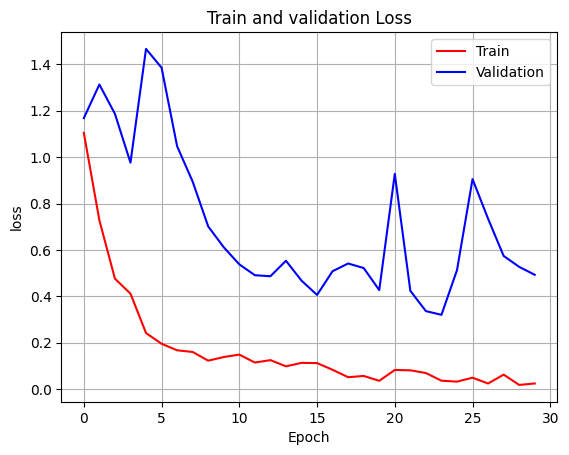

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
plt.title('Train and validation Loss')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend();

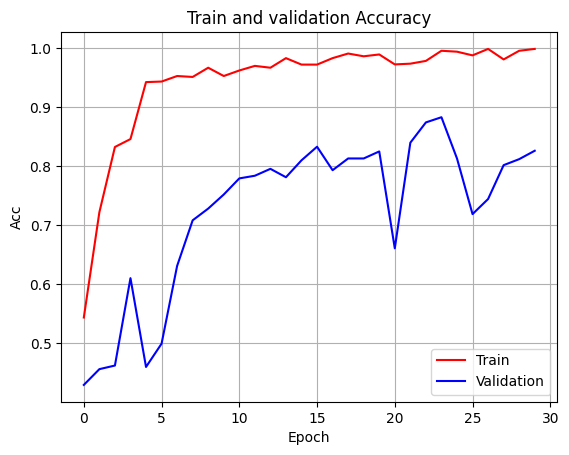

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')
plt.title('Train and validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend();

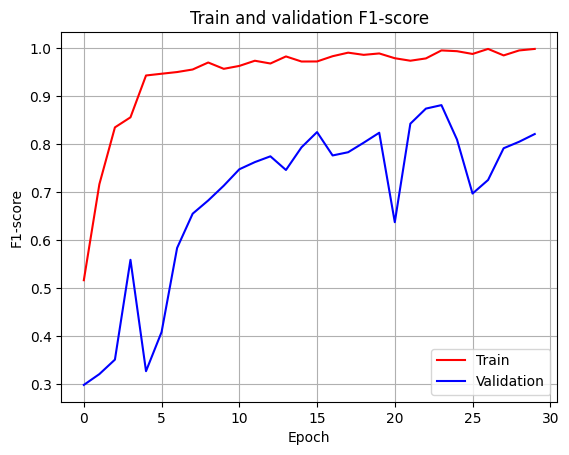

In [ ]:
plt.plot(range(epoch_counter), f1_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), f1_valid_hist, 'b-', label='Validation')
plt.title('Train and validation F1-score')

plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.grid(True)
plt.legend();

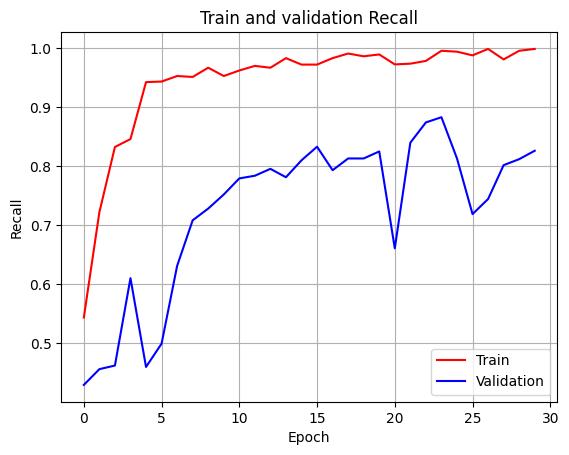

In [ ]:
plt.plot(range(epoch_counter), recall_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), recall_valid_hist, 'b-', label='Validation')
plt.title('Train and validation Recall')

plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.legend();

## Test model on Test dataset

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("/content/model.pt")
model.to(device)
model.eval()

# Define a list to store the true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test loader and make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.append(predicted.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

# Combine the true and predicted labels into a single array
true_labels = np.concatenate(true_labels, axis=0)
predicted_labels = np.concatenate(predicted_labels, axis=0)

# Compute the accuracy, F1 score, and recall
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print("Accuracy: {:.2f}%".format(100 * accuracy))
print("F1 Score: {:.2f}%".format(100 * f1))
print("Recall: {:.2f}%".format(100 * recall))

Accuracy: 88.25%
F1 Score: 88.22%
Recall: 88.25%
